In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


CUDA_VISIBLE_DEVICES: 4 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [2]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud Tour, Loud}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

In [10]:
df = df_raw.copy()
df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
df = df[df["evidence_sents"].str.len() == 1]  # 1 Evidence Sentence
df = df[df["head_entity"].str.len() == 1]  # 1 Head
df = df[df["head_entity_in_evidence"].str.len() >= 1]  # 1 Head in Evidence
df = df[df["head_entity_names"].str.len() == 1]  # All heads have the same name
print(len(df))

# Filter Repeated Labels (Only 1 h->t)
def not_repeated_label(label, labels):
    repeat_count = 0
    for l in labels:
        if l['h'] == label['h'] and l['t'] == label['t']:
            repeat_count += 1
    return True if repeat_count == 1 else False
df["repeated_label"] = df.apply(lambda r: not_repeated_label(r["label"], r["labels"]), axis=1)
df = df[df["repeated_label"]]
print(len(df))

df = df.sample(frac=1, random_state=0)
df = df.drop_duplicates(subset=["title"])
print(len(df))

df = df.sample(250, random_state=0)
print(len(df))

def flatten(xss):
    return [x for xs in xss for x in xs]

df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))
df["sents_evidence_single"] = df["evidence_sents"].apply(lambda x: " ".join(flatten(x)))
df["sents_evidence_redundant"] = df.apply(lambda r: r["sents_evidence_single"] + " " + df[df['title'] != r['title']].sample(1, random_state=0)["sents_complete"].values[0], axis=1)
df["sents_evidence_doc"] = df.apply(lambda r: r["sents_evidence_single"] + " " + r["sents_complete"].replace(r["sents_evidence_single"], ""), axis=1)

sents_cols = []
### evidence > evidence + redundant long text
sents_cols.append(f"sents_evidence_single")
# sents_cols.append(f"sents_evidence_redundant")  # 35
sents_cols.append(f"sents_evidence_doc")  # 17

print(df["title"].value_counts())

save_cols = [
    "query", "gold_docs", "gold_docs_text", "scores_stats", "scores_gold", "predicted_docs_text_10", "id", "title", "vertexSet", 
    "labels", "sents", "split", "label", "label_idx", "head_entity", 
    "tail_entity", "head_entity_names", "tail_entity_names", 
    "head_entity_longest_name", "tail_entity_longest_name", 
    "head_entity_types", "tail_entity_types", "evidence_sent_ids", 
    "evidence_sents", "head_entity_in_evidence", "tail_entity_in_evidence", 
    "relation", "relation_name", "query_question", "duplicate_titles_len", 
    "duplicate_titles", "hit_rank", "gold_doc", "gold_doc_title", 
    "gold_doc_text", "gold_doc_score", "pred_doc", "pred_doc_title", 
    "pred_doc_text", "pred_doc_score", "gold_doc_len", "pred_doc_len",
] + sents_cols
df[save_cols].to_json("dataset/brevity_bias.jsonl", orient="records", lines=True)

df.sample(2)

1819
1247
500
250
title
House of Angels                  1
Usain Bolt Sports Complex        1
USS Lyndon B. Johnson            1
New Haven Harbor                 1
Black Lake (Michigan)            1
                                ..
Louis Lombardi                   1
John Ripley (USMC)               1
Brother Man                      1
Township High School District    1
Across the Black Waters          1
Name: count, Length: 250, dtype: int64


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,repeated_label,sents_complete,sents_evidence_single,sents_evidence_redundant,sents_evidence_doc
2401,test10961,Which league is Providence Steamrollers part of?,[George Nostrand],"{'George Nostrand': {'text': 'George Thomas Nostrand ( January 25 , 1924 – November 8 , 1981 ) was an American professional basketball player . A 6'8 "" ( 2.03 m ) forward / center from High Point University ( 1941 – 1944 ) and the University of Wyoming ( 1944 – 1945 ) , Nostrand played four seasons ( 1946–1950 ) in the National Basketball Association as a member of the Toronto Huskies , Cleveland Rebels , Providence Steamrollers , Boston Celtics , Tri - Cities Blackhawks , and Chicago Stags . He averaged 8.2 points per game in his professional career . Nostrand is perhaps best known for appearing in a series of Canadian newspaper advertisements to promote the first National Basketball Association game , a November 1 , 1946 contest between Nostrand 's Toronto Huskies and the New York Knicks . The advertisements promised that anyone taller than Nostrand would receive free admission to the opening game .', 'title': 'George Nostrand'}}","{'len': 1000, 'max': 387.0050048828125, 'min': 379.3568420410156, 'std': 1.2129732347178745, 'mean': 380.62697122192384, 'median': 380.2494201660156}",{'George Nostrand': None},"{'New Orleans Baby Cakes': 387.0050048828125, 'Hampton Roads Piranhas': 386.4652099609375, 'Pittsburgh Filipinos': 385.80908203125, 'Reading Red Sox': 385.79412841796875, 'North Country Baseball League': 385.7139587402344, 'Consolidated Credit Union Place': 385.4960021972656, 'Virginia Beach Piranhas': 385.4434509277344, 'Providence, Caswell County, North Carolina': 385.42803955078125, 'New England Tea Men': 385.12469482421875, 'Philadelphia Liberty FC': 384.9697265625, 'Regional Sparkasse League': 384.81719970703125, 'Nick Sakiewicz': 384.6709289550781, 'National Basketball League (New Zealand)': 384.6403503417969, 'New York Athletic Club S.C.': 384.27630615234375, 'Antigua Hawksbills': 384.2123718261719, 'Toronto Triumph': 384.2101745605469, 'Minnesota Monarchs': 384.2049560546875, 'Top League': 384.18292236328125, 'United States Chess League': 384.1654968261719, 'Providence (Charleroi Metro)': 384.1471252441406, 'Central Coast Mariners FC league record by opponent': 384.09405517578125, 'Women's Labour League': 384.07110595703125, 'North West Senior League': 384.0516662597656, 'Coloured Hockey League': 383.973876953125, 'Wigan St Patricks': 383.9420166015625, 'Cincinnati Ladyhawks': 383.9363098144531, 'The League of Extraordinary Gentlemen, Volume II': 383.9209899902344, 'Pacific Coast International League': 383.91888427734375, 'Long Island Rough Riders (UWS)': 383.84674072265625, 'Lou D'Alpuget': 383.81854248046875, 'Wild League': 383.8034973144531, 'United Collegiate Hockey Conference': 383.7903137207031, 'Nashville Xpress': 383.7781982421875, 'White League'

In [11]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", verbose=True, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.verbose = verbose
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False), disable=not self.verbose):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        if self.verbose: print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

In [12]:
### RUN MODELS AND COMPUTE DOT SCORES
def digitize_col(df_col, bins) -> pd.DataFrame:
    return pd.cut(df_col, bins=bins)

cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/dragon-roberta-query-encoder", "facebook/dragon-roberta-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("facebook/contriever", "facebook/contriever", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
    ("Shitao/RetroMAE_MSMARCO_finetune", "Shitao/RetroMAE_MSMARCO_finetune", "cls"),
    
    # ("Shitao/RetroMAE", "Shitao/RetroMAE", "cls"),
    # ("Shitao/RetroMAE_MSMARCO", "Shitao/RetroMAE_MSMARCO", "cls"),
]

plot_col_dots = []
for query_model, context_model, POOLING in tqdm(cfgs):
    dpr = YourCustomDEModel(query_model, context_model, POOLING, verbose=False)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df['query'].to_list())
    for sent_col in tqdm(sents_cols, desc=f"{query_model}"):
        embds = dpr.encode_corpus(to_doc_format(df[sent_col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds)).cpu().numpy()
        new_col = f"{query_model}_{sent_col}_dot"
        # print(new_col)
        df[new_col] = embds_dot
        plot_col_dots.append(new_col)

df_dot = df.copy()

  0%|          | 0/6 [00:00<?, ?it/s]

facebook/dragon-plus-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/dragon-roberta-query-encoder:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/contriever-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

facebook/contriever:   0%|          | 0/2 [00:00<?, ?it/s]

OpenMatch/cocodr-base-msmarco:   0%|          | 0/2 [00:00<?, ?it/s]

Shitao/RetroMAE_MSMARCO_finetune:   0%|          | 0/2 [00:00<?, ?it/s]

['facebook/dragon-plus-query-encoder_sents_evidence_single_dot', 'facebook/dragon-plus-query-encoder_sents_evidence_doc_dot', 'facebook/dragon-roberta-query-encoder_sents_evidence_single_dot', 'facebook/dragon-roberta-query-encoder_sents_evidence_doc_dot', 'facebook/contriever-msmarco_sents_evidence_single_dot', 'facebook/contriever-msmarco_sents_evidence_doc_dot', 'facebook/contriever_sents_evidence_single_dot', 'facebook/contriever_sents_evidence_doc_dot', 'OpenMatch/cocodr-base-msmarco_sents_evidence_single_dot', 'OpenMatch/cocodr-base-msmarco_sents_evidence_doc_dot', 'Shitao/RetroMAE_MSMARCO_finetune_sents_evidence_single_dot', 'Shitao/RetroMAE_MSMARCO_finetune_sents_evidence_doc_dot']


  0%|          | 0/6 [00:00<?, ?it/s]

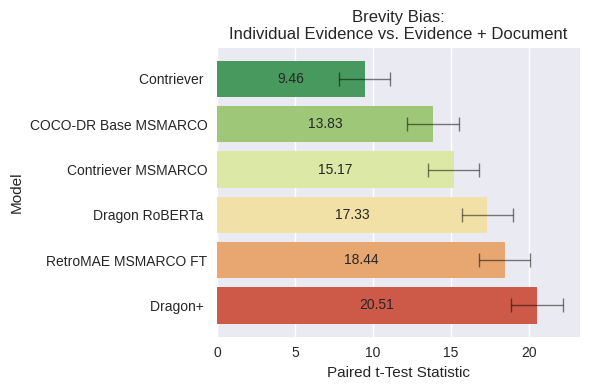

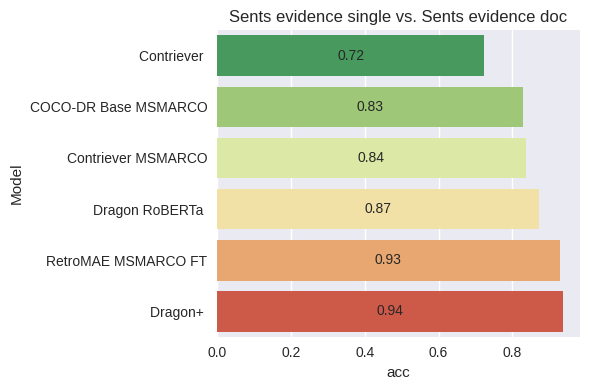

,Model,col1,col2,Paired t-Test Statistic,ttest_pvalue,ttest_ci_low_stats,ttest_ci_high_stats,ttest_ci_low,ttest_ci_high,standard_ttest_ppf,acc,mean_diff,std_diff,n
0,Contriever,facebook/contriever_sents_evidence_single_dot,facebook/contriever_sents_evidence_doc_dot,9.464815,2.349594e-18,0.055449,0.084590,1.650996,1.650996,-1.650996,0.724,0.070019,0.116970,250
0,COCO-DR Base MSMARCO,OpenMatch/cocodr-base-msmarco_sents_evidence_single_dot,OpenMatch/cocodr-base-msmarco_sents_evidence_doc_dot,13.833732,1.130841e-32,1.708107,2.275222,1.650996,1.650996,-1.650996,0.828,1.991665,2.276391,250
0,Contriever MSMARCO,facebook/contriever-msmarco_sents_evidence_single_dot,facebook/contriever-msmarco_sents_evidence_doc_dot,15.169948,2.961226e-37,0.152725,0.198299,1.650996,1.650996,-1.650996,0.836,0.175512,0.182933,250
0,Dragon RoBERTa,facebook/dragon-roberta-query-encoder_sents_evidence_single_dot,facebook/dragon-roberta-query-encoder_sents_evidence_doc_dot,17.331588,1.110048e-44,3.504732,4.403401,1.650996,1.650996,-1.650996,0.872,3.954067,3.607245,250
0,RetroMAE MSMARCO FT,Shitao/RetroMAE_MSMARCO_finetune_sents_evidence_single_dot,Shitao/RetroMAE_MSMARCO_finetune_sents_evidence_doc_dot,18.444537,1.780047e-48,4.461809,5.528600,1.650996,1.650996,-1.650996,0.928,4.995204,4.282087,250
0,Dragon+,facebook/dragon-plus-query-encoder_sents_evidence_single_dot,facebook/dragon-plus-query-encoder_sents_evidence_doc_dot,20.511225,2.028724e-55,4.276065,5.184490,1.650996,1.650996,-1.650996,0.936,4.730278,3.646406,250


In [14]:
df = df_dot.copy()
print(plot_col_dots)

def standard_ttest_ppf(n, confidence_level=0.95):
    return stats.t.ppf(q=1-confidence_level, df=n-1, loc=0, scale=1)

results_df = pd.DataFrame()
for query_model, context_model, POOLING in tqdm(cfgs):
    ### T-TEST
    rdf = []
    for col1 in plot_col_dots:
        for col2 in plot_col_dots:
            if query_model == col1.split("_sents")[0] and query_model == col2.split("_sents")[0] and col1 != col2 and sents_cols[0] in col1:
                ttest = stats.ttest_rel(df[col1], df[col2])
                rdf.append({
                    "query_model": query_model,
                    "col1": col1,
                    "col2": col2,
                    "ttest_stats": ttest[0],
                    "ttest_pvalue": ttest[1],
                    "ttest_ci_low_stats": ttest.confidence_interval(confidence_level=0.95)[0],
                    "ttest_ci_high_stats": ttest.confidence_interval(confidence_level=0.95)[1],
                    "ttest_ci_low": np.abs(standard_ttest_ppf(len(df))),
                    "ttest_ci_high": np.abs(standard_ttest_ppf(len(df))),
                    "standard_ttest_ppf": standard_ttest_ppf(len(df)),
                    "acc": (df[col1] > df[col2]).mean(),
                    "mean_diff": (df[col1] - df[col2]).mean(),
                    "std_diff": (df[col1] - df[col2]).std(),
                    "n": len(df),
                })
    rdf = pd.DataFrame(rdf)
    results_df = pd.concat([results_df, rdf]).sort_values("ttest_stats", ascending=True)

### PLOT
model_mappings = {
    "OpenMatch/cocodr-base-msmarco": ("COCO-DR", "Base MSMARCO"),
    "Shitao/RetroMAE_MSMARCO_finetune": ("RetroMAE", "MSMARCO FT"),
    "Shitao/RetroMAE_MSMARCO": ("RetroMAE", "MSMARCO"),
    "Shitao/RetroMAE": ("RetroMAE", ""),
    "facebook/contriever-msmarco": ("Contriever", "MSMARCO"),
    "facebook/contriever": ("Contriever", ""),
    "facebook/dragon-plus-query-encoder": ("Dragon+", ""),
    "facebook/dragon-roberta-query-encoder": ("Dragon RoBERTa", ""),
}
results_df["query_model"] = results_df["query_model"].apply(lambda x: model_mappings[x][0] + " " + model_mappings[x][1])
results_df.rename(columns={"ttest_stats": "Paired t-Test Statistic", "query_model": "Model"}, inplace=True)

### PLOT T-TEST
plt.figure(figsize=(6, 4))
plt.title(f"Brevity Bias:\nIndividual Evidence vs. Evidence + Document")
results_df.to_json("results/brevity_df.json", orient="records")
ax = sns.barplot(
    data=results_df, y="Model", x="Paired t-Test Statistic", palette=sns.color_palette("RdYlGn_r"), hue="Model",
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
ax.errorbar(x=results_df["Paired t-Test Statistic"], y=results_df["Model"], xerr=results_df[["ttest_ci_low", "ttest_ci_high"]].T.to_numpy(), fmt="none", c="k", capsize=5, elinewidth=1, markeredgewidth=1, alpha=0.5)
plt.tight_layout()
plt.savefig("figs/brevity_ttest.pdf")
plt.show()

### PLOT T-TEST
plt.figure(figsize=(6, 4))
plt.title(f"{sents_cols[0].replace('_', ' ').capitalize()} vs. {sents_cols[1].replace('_', ' ').capitalize()}")
ax = sns.barplot(
    data=results_df, y="Model", x="acc", palette=sns.color_palette("RdYlGn_r"), hue="Model",
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10)
plt.tight_layout()
plt.show()
# plt.savefig("figs/tail_foil_ttest.pdf")

results_df

In [7]:
results_df[["Model", "Paired t-Test Statistic", "mean_diff", "std_diff", "n"]]

,Model,Paired t-Test Statistic,mean_diff,std_diff,n
0,Contriever,2.653833,0.018820,0.112127,250
0,COCO-DR Base MSMARCO,8.650941,1.022497,1.868825,250
0,RetroMAE MSMARCO FT,12.564399,2.410981,3.034046,250
0,Contriever MSMARCO,12.707058,0.110721,0.137771,250
0,Dragon RoBERTa,12.997666,2.302608,2.801074,250
0,Dragon+,15.541415,2.724378,2.771704,250


In [8]:
results_df[["Model", "Paired t-Test Statistic", "mean_diff", "std_diff", "n"]]

,Model,Paired t-Test Statistic,mean_diff,std_diff,n
0,Contriever,2.653833,0.018820,0.112127,250
0,COCO-DR Base MSMARCO,8.650941,1.022497,1.868825,250
0,RetroMAE MSMARCO FT,12.564399,2.410981,3.034046,250
0,Contriever MSMARCO,12.707058,0.110721,0.137771,250
0,Dragon RoBERTa,12.997666,2.302608,2.801074,250
0,Dragon+,15.541415,2.724378,2.771704,250


In [9]:
results_df["t"] = results_df.apply(lambda r: r["mean_diff"]/r["std_diff"]*np.sqrt(r['n']), axis=1)
results_df["tm"] = results_df.apply(lambda r: r["mean_diff"]/r["std_diff"], axis=1)
results_df[["Model", "Paired t-Test Statistic", "mean_diff", "std_diff", "n", "t", "tm"]]

,Model,Paired t-Test Statistic,mean_diff,std_diff,n,t,tm
0,Contriever,2.653833,0.018820,0.112127,250,2.653833,0.167843
0,COCO-DR Base MSMARCO,8.650941,1.022497,1.868825,250,8.650941,0.547134
0,RetroMAE MSMARCO FT,12.564399,2.410981,3.034046,250,12.564399,0.794642
0,Contriever MSMARCO,12.707058,0.110721,0.137771,250,12.707058,0.803665
0,Dragon RoBERTa,12.997666,2.302608,2.801074,250,12.997667,0.822045
0,Dragon+,15.541415,2.724378,2.771704,250,15.541413,0.982925


In [9]:
# Find Example
pd.set_option('display.max_colwidth', 1800)
df = df_dot.copy()
df["diff"] = df["facebook/dragon-plus-query-encoder_sents_evidence_single_dot"] - df["facebook/dragon-plus-query-encoder_sents_evidence_doc_dot"]
df["evidence_text"] = df["evidence_sents"].apply(lambda x: " ".join(flatten(x)))
df["evidence_len"] = df["evidence_text"].apply(lambda x: len(x.split()))
print(df["evidence_len"].describe())
df = df[df["evidence_len"] < 20]
df[sents_cols + ["title", "query", "evidence_text", "gold_doc_len", "diff", "tail_entity"]].sort_values("diff", ascending=False)

count    250.000000
mean      31.344000
std       14.815657
min        9.000000
25%       21.250000
50%       29.500000
75%       37.750000
max      112.000000
Name: evidence_len, dtype: float64


,sents_evidence_single,sents_evidence_doc,title,query,evidence_text,gold_doc_len,diff,tail_entity
4308,In 1997 starred in telenovela El alma no tiene color .,"In 1997 starred in telenovela El alma no tiene color . Ernesto D'Alessio ( born Ernesto Alonso Vargas Contreras on June 3 , 1977 in Mexico City , Mexico ) is a Mexican actor and singer . D'Alessio was born in Mexico City in 1977 . He is son of Mexican singer and actress Lupita D'Alessio and the singer and actor Jorge Vargas . Has a one older brother Jorge Francisco ( deceased ) and a younger brother , two younger half - sisters of the second marriage of his father , and a younger half - brother of the fifth marriage of his mother . In 1990 his debut as an actor . In 1999 played as Mateo in . In 2005 starred in Contra viento y marea as main antagonist . In 2006 his participated in reality show Cantando por un sueño and finished in 3rd place . The same year his participated in another reality show , in Reyes de la canción and finished in 2nd place .",Ernesto D'Alessio,When was El alma no tiene color published?,In 1997 starred in telenovela El alma no tiene color .,173,14.257874,"[{'type': 'TIME', 'pos': [1, 2], 'name': '1997', 'sent_id': 5, 'global_pos': [104, 104], 'index': '11_0'}]"
6762,"He also wrote and directed the film Dough Boys , released in 2008 .","He also wrote and directed the film Dough Boys , released in 2008 . Louis Lombardi ( born January 17 , 1968 ) is an American actor . Lombardi was born in The Bronx , New York City , the son of Louis Lombardi , Sr . On television , Lombardi had a recurring role on The Sopranos as Agent Skip Lipari , and guest starred on such shows as Entourage , Heroes and . He was a cast member of a 1990s revival of Fantasy Island and played Edgar Stiles on 24 . He also played Stucky Fein in the short - lived television show Mob City . He has had roles in films including Beer League , The Usual Suspects , Natural Born Killers , Suicide Kings , Beverly Hills Cop III , The Animal , Spider - Man 2 , 3000 Miles to Graceland , The Crew , The Hot Chick , The Spirit , Battleship , and Jersey Boys .",Louis Lombardi,When was Dough Boys published?,"He also wrote and directed the film Dough Boys , released in 2008 .",166,13.076874,"[{'type': 'TIME', 'pos': [12, 13], 'name': '2008', 'sent_id': 5, 'global_pos': [162, 162], 'index': '29_0'}]"
2930,"Rudolph Palm , Curaçao ( 1880 – 1950 )","Rudolph Palm , Curaçao ( 1880 – 1950 ) This is a list of composers of Caribbean descent . The Caribbean is a region consisting of the Caribbean Sea , its islands ( most of which are enclosed by the sea ) , and the surrounding coasts . The region is located southeast of the Gulf of Mexico and North America , east of Central America , and to the north of South America . The Caribbean has produced many notable composers , who have contributed in a variety of ways to the history of Western classical music . Jan Gerard Palm , Curaçao ( 1831 – 1906 ) Ignacio Cervantes , Cuba ( 1847 – 1905 ) Louis Moreau Gottschalk , New Orleans , United States ( 1829 – 1869 ) Ludovic Lamothe , Haiti ( 1882 – 1953 ) Jacobo Palm , Curaçao ( 1887 – 1982 ) John Palm Curaçao ( 1885 – 1925 ) Jose de Lima , Curaçao ( 1890 – 1972 ) Wim Statius Muller , Curaçao ( 1930 ) José Luis Rodríguez Vélez , Panama ( 1915 – 1984 )",List of composers of Caribbean descent,When did Rudolph Palm die?,"Rudolph Palm , Curaçao ( 1880 – 1950 )",193,12.884369,"[{'type': 'TIME', 'pos': [7, 8], 'name': '1950', 'sent_id': 8, 'global_pos': [139, 139], 'index': '26_0'}]"
2515,In 1978 his Concerto Grosso was awarded the Stockhausen International Prize in Composition .,"In 1978 his Concerto Grosso was awarded the Stockhausen International Prize in Composition . Robert Walter Moevs ( 2 December 1920 , in La Crosse , Wisconsin – 10 December 2007 ) was an American composer of contemporary classical music . He was known for his highly chromatic music . Moevs served in the United States Army Air Forces as a pilot during World 